# Unsupervised Learning

# Abstract 

In this notebook we studied **unsupervised learning** considering two important and representative algorithms: **PCA** and **k-means**.

First, we implemented the PCA algorithm step by step; we then run the algorithm on synthetic data in order to see its working and evaluate when it may make sense to use it and when not. We then considered two typical uses of PCA: for **visualization** on the *iris* dataset, and for **compression-decompression** on the *lfw* dateset.

We then moved to consider the k-means algorithm. In this case we used the implementation provided by *scikit-learn* and we applied it to another prototypical unsupervised learning problem: **clustering**; we used *k-means* to process the *iris* dataset and we evaluated the results visually.

In the final part, we considered two additional questions that may arise when using the above algorithms. For PCA, we considered the problem of **selection of hyper-parameters**, that is, how we can select the hyper-parameter of ou algorithm in a reasonable fashion. For k-means, we considered the problem of the **quantitative evaluation** of our results, that is, how can we measure the performance or usefulness of our algorithms. 

### Goals of the exercise
This project has three parts. The first part is focused on Principal Component Analysis (PCA). We will implent PCA from scratch to do compression and visualization of data.

The second part focuses on clustering using K-means. We will use `scikit-learn` to run K-means clustering, and use PCA to visualize the results.

The last part ties supervised and unsupervised learning together in an effort to evaluate the output of K-means using a logistic regression for multi-class classification approach.


### Tools
In the first part about PCA we will **NOT** use ML libraries. In the K-means part and beyond we will use `scikit-learn` to iterate quickly on the problems.

## Principal Component Analysis (PCA)

### Importing libraries
We start importing the *numpy* library for performing matrix computations, the *pyplot* library for plotting data, and the *syntheticdata* module to import synthetic data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import syntheticdata

### Centering the Data

In [1]:
def center_data(A):
    """
    INPUT:
        A    [NxM] numpy data matrix (N samples, M features)
    
    OUTPUT:
        X    [NxM] numpy centered data matrix (N samples, M features)
    """
    N,M = A.shape
    average = np.zeros(M)
    for n in A:
        average += n
    average = average/N
    return A-average

Testing the function on *testcase*:

In [3]:
testcase = np.array([[3.,11.,4.3],[4.,5.,4.3],[5.,17.,4.5],[4,13.,4.4]])
answer = np.array([[-1.,-0.5,-0.075],[0.,-6.5,-0.075],[1.,5.5,0.125],[0.,1.5,0.025]])
np.testing.assert_array_almost_equal(center_data(testcase), answer)

### Computing Covariance Matrix
Here we implement a function with the following signature to compute the covariance matrix.

In [4]:
def compute_covariance_matrix(A):
    """
    INPUT:
        A    [NxM] centered numpy data matrix (N samples, M features)
    
    OUTPUT:
        C    [MxM] numpy covariance matrix (M features, M features)
    """
    C = 1/A.shape[0]*(A.T @ A)
    return C

We test our function, checking the following assertion on *testcase*:

In [5]:
testcase = center_data(np.array([[22.,11.,5.5],[10.,5.,2.5],[34.,17.,8.5],[28.,14.,7]]))
answer = np.array([[580.,290.,145.],[290.,145.,72.5],[145.,72.5,36.25]])

# Depending on implementation the scale can be different:
to_test = compute_covariance_matrix(testcase)

answer = answer/answer[0, 0]
to_test = to_test/to_test[0, 0]

np.testing.assert_array_almost_equal(to_test, answer)

### Computing eigenvalues and eigenvectors
Here we use the linear algebra package of `numpy` and its function `np.linalg.eig()` to compute eigenvalues and eigenvectors. Notice that we take the real part of the eigenvectors and eigenvalues. The covriance matrix *should* be a symmetric matrix, but the actual implementation in `compute_covariance_matrix()` can lead to small round off errors that lead to tiny imaginary additions to the eigenvalues and eigenvectors. These are purely numerical artifacts that we can safely remove.

In [6]:
def compute_eigenvalue_eigenvectors(A):
    """INPUT:
        A    [DxD] numpy matrix
    
    OUTPUT:
        eigval    [D] numpy vector of eigenvalues
        eigvec    [DxD] numpy array of eigenvectors
    """
    
    eigval, eigvec = np.linalg.eig(A)
    
    # Numerical roundoff can lead to (tiny) imaginary parts. We correct that here.
    eigval = eigval.real
    eigvec = eigvec.real
    
    return eigval, eigvec

We test our function, checking the following assertion on *testcase*:

In [7]:
testcase = np.array([[2,0,0],[0,5,0],[0,0,3]])
answer1 = np.array([2.,5.,3.])
answer2 = np.array([[1.,0.,0.],[0.,1.,0.],[0.,0.,1.]])
x,y = compute_eigenvalue_eigenvectors(testcase)
np.testing.assert_array_almost_equal(x, answer1)
np.testing.assert_array_almost_equal(y, answer2)

### Sorting eigenvalues and eigenvectors
Now we implement a function to sort eigenvalues and eigenvectors.

In [8]:
def sort_eigenvalue_eigenvectors(eigval, eigvec):
    """
    INPUT:
        eigval    [D] numpy vector of eigenvalues
        eigvec    [DxD] numpy array of eigenvectors
    
    OUTPUT:
        sorted_eigval    [D] numpy vector of eigenvalues
        sorted_eigvec    [DxD] numpy array of eigenvectors
    """
    #obtains the descending order of the eigenvalues
    permutation = eigval.argsort()[::-1]
    sorted_eigval = eigval[permutation]
    sorted_eigvec = eigvec[:,permutation]
    
    return sorted_eigval, sorted_eigvec

Testing

In [9]:
testcase = np.array([[2,0,0],[0,5,0],[0,0,3]])
answer1 = np.array([5.,3.,2.])
answer2 = np.array([[0.,0.,1.],[1.,0.,0.],[0.,1.,0.]])
x,y = compute_eigenvalue_eigenvectors(testcase)
x,y = sort_eigenvalue_eigenvectors(x,y)
np.testing.assert_array_almost_equal(x, answer1)
np.testing.assert_array_almost_equal(y, answer2)

### PCA Algorithm
We will now implement a function to compute PCA using the functions implemented above.

In [10]:
def pca(A,m):
    """
    INPUT:
        A    [NxM] numpy data matrix (N samples, M features)
        m    integer number denoting the number of learned features (m <= M)
    
    OUTPUT:
        pca_eigvec    [Mxm] numpy matrix containing the eigenvectors (M dimensions, m eigenvectors)
        P             [Nxm] numpy PCA data matrix (N samples, m features)
    """
    C = compute_covariance_matrix(center_data(A))
    
    # getting sorted, centered eigenvalues and corresponding eigenvectors from C
    eigval, eigvec = sort_eigenvalue_eigenvectors(*compute_eigenvalue_eigenvectors(C))
    pca_eigvec = eigvec[:,:m]
    
    # produce the new data matrix 
    P = center_data(A) @ pca_eigvec
    
    return pca_eigvec, P

Testing

In [11]:
testcase = np.array([[22.,11.,5.5],[10.,5.,2.5],[34.,17.,8.5]])
x, y = pca(testcase,2)

import pickle
answer1_file = open('PCAanswer1.pkl','rb'); answer2_file = open('PCAanswer2.pkl','rb')
answer1 = pickle.load(answer1_file); answer2 = pickle.load(answer2_file)


test_arr_x = np.sum(np.abs(np.abs(x) - np.abs(answer1)), axis=0)
np.testing.assert_array_almost_equal(test_arr_x, np.zeros(2))


test_arr_y = np.sum(np.abs(np.abs(y) - np.abs(answer2)))
np.testing.assert_almost_equal(test_arr_y, 0)

## Understanding the PCA
We now use the PCA algorithm you implemented on a toy data set in order to understand its inner workings.

### Loading the data
The module *syntheticdata* provides a small synthetic dataset of dimension [100x2] (100 samples, 2 features).

In [12]:
X = syntheticdata.get_synthetic_data1()

### Visualizing the data
We will visualize the synthetic data using the function *scatter()* from the *matplotlib* library.

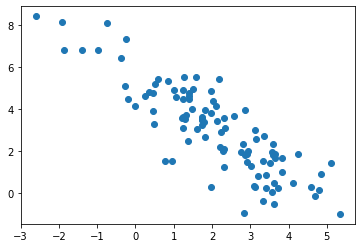

In [13]:
plt.scatter(X[:,0],X[:,1])

### Visualize the centered data
Notice that the data visualized above is not centered on the origin (0,0). So we will use the function defined above to center the data, and the replot it.

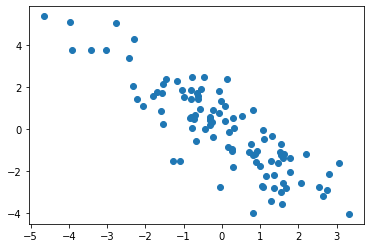

In [14]:
X = center_data(X)
plt.scatter(X[:,0],X[:,1])

### Visualize the first eigenvector
Here we visualize the vector defined by the first eigenvector.

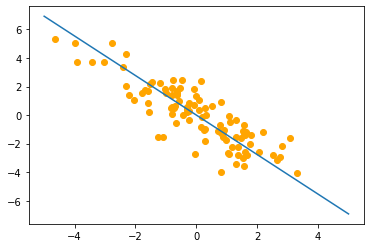

In [15]:
pca_eigvec, _ = pca(X,X.shape[0])
first_eigvec = pca_eigvec[0]

plt.scatter(X[:,0],X[:,1], c="orange")

x = np.linspace(-5, 5, 1000)
y = first_eigvec[1]/first_eigvec[0] * x
plt.plot(x,y)

### Visualize the PCA projection
Finally, we will use the *PCA()* algorithm to project on a single dimension and visualize the result using again the *scatter()* function.

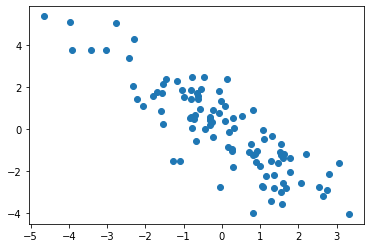

In [16]:
_,P = pca(X,X.shape[0])
plt.scatter(X[:,0],X[:,1])

## Evaluation
So far we have used PCA on synthetic data. Let us now imagine we are using PCA as a pre-processing step before a classification task.

### Loading the first set of labels
The function *get_synthetic_data_with_labels1()* from the module *syntethicdata* provides a first labeled dataset.

In [17]:
X,y = syntheticdata.get_synthetic_data_with_labels1()

### Running PCA
We will process the data using the PCA algorithm and project it in one dimension. Then we will plot the labeled data using *scatter()* before and after running PCA.

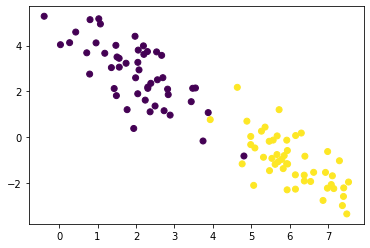

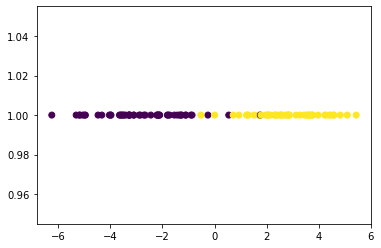

In [18]:
plt.scatter(X[:,0],X[:,1],c=y[:,0])

plt.figure()
_,P = pca(X,X.shape[0])
plt.scatter(P[:,0],np.ones(P.shape[0]),c=y[:,0])

It almost seems possible to make a linear decision boundary between the two features. Plotting in one dimension does not really hurt this intuition as the points are fairly segregated along the axis with the most variance, which is what we get with the PCA.

### Loading the second set of labels
The function *get_synthetic_data_with_labels2()* from the module *syntethicdata* provides a second labeled dataset.

In [19]:
X,y = syntheticdata.get_synthetic_data_with_labels2()

### Running PCA
As before, we process the data using the PCA algorithm and project it in one dimension, then plot the labeled data using *scatter()* before and after running PCA.

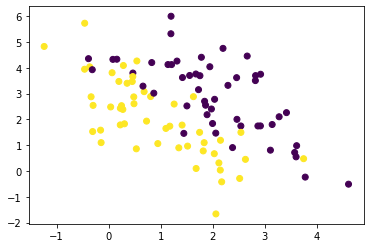

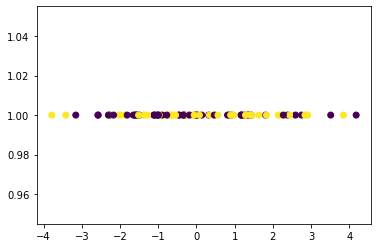

In [20]:
plt.scatter(X[:,0],X[:,1],c=y[:,0])

plt.figure()
_,P = pca(X,X.shape[0])
plt.scatter(P[:,0],np.ones(P.shape[0]),c=y[:,0])

The sense of boundary completely vanishes for this set as it is projected onto one dimension

Projecting along the second eigenvector would have had a clearer separation of the features as the second axis has a greater imbalance of the different points on each side. I assume both would be even better as you would have more space to work with.

## Case study 1: PCA for visualization
We now consider the *iris* dataset, a simple collection of data (N=150) describing iris flowers with four (M=4) features. The features are: Sepal Length, Sepal Width, Petal Length and Petal Width. Each sample has a label, identifying each flower as one of 3 possible types of iris: Setosa, Versicolour, and Virginica.

Visualizing a 4-dimensional dataset is impossible; therefore we will use PCA to project our data in 2 dimensions and visualize it.

### Loading the data
The function *get_iris_data()* from the module *syntethicdata* returns the *iris* dataset. It returns a data matrix of dimension [150x4] and a label vector of dimension [150].

In [21]:
X,y = syntheticdata.get_iris_data()

### Visualizing the data by selecting features
We will try to visualize the data (using label information) by randomly selecting two out of the four features of the data.

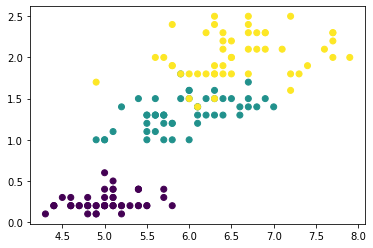

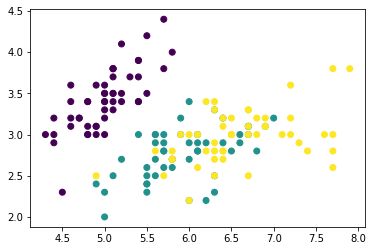

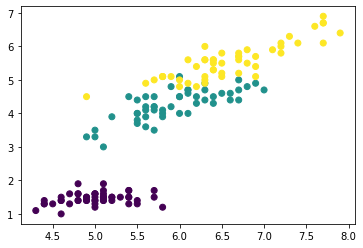

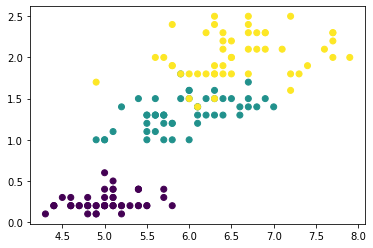

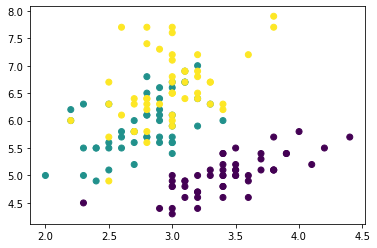

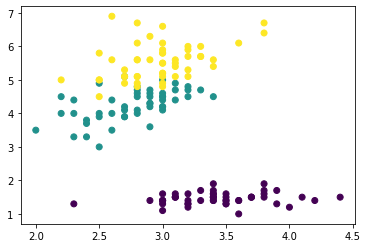

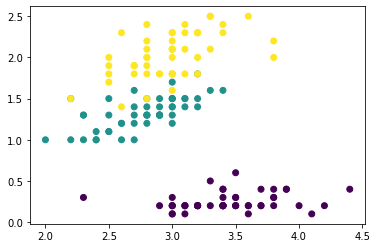

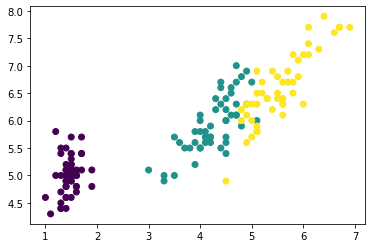

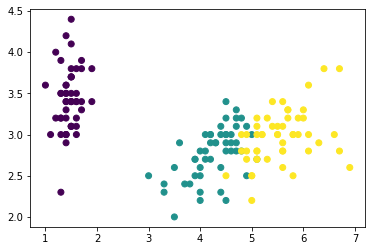

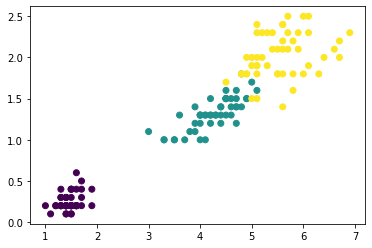

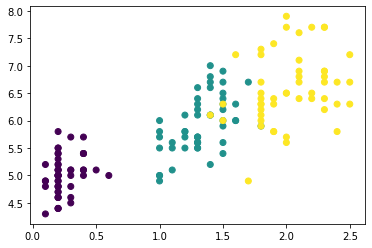

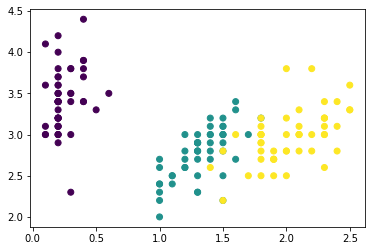

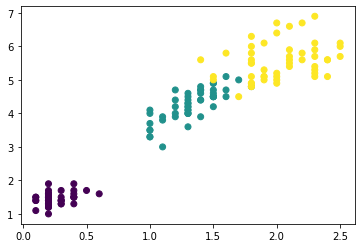

<Figure size 432x288 with 0 Axes>

In [22]:
plt.scatter(X[:,0],X[:,3],c=y)
plt.figure()
plt.scatter

for i in range(4):
    for j in range(4):
        if i != j:
            plt.scatter(X[:,i], X[:,j], c=y)
            plt.figure()
        

### Visualizing the data by PCA
Here we process the data using PCA and visualize it.

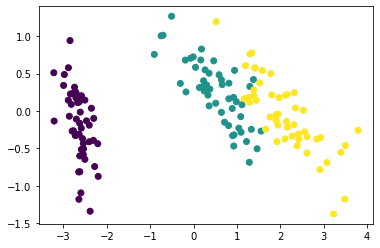

In [23]:
plt.figure()
_,P = pca(X,X.shape[0])
plt.scatter(P[:,0],P[:,1],c=y)

I think the PCA separates the teal and yellow colored features a little better than any of the other visualizations above

## Case study 2: PCA for compression
We now consider the *faces in the wild (lfw)* dataset, a collection of pictures (N=1280) of people. Each pixel in the image is a feature (M=2914).

### Loading the data
The function *get_lfw_data()* from the module *syntethicdata* returns the *lfw* dataset. It returns a data matrix of dimension [1280x2914] and a label vector of dimension [1280]. It also returns two parameters, $h$ and $w$, reporting the height and the width of the images (these parameters are necessary to plot the data samples as images). 
<br><br>
Nota bene, it might take some time to download the data.

In [24]:
X,y,h,w = syntheticdata.get_lfw_data()

### Inspecting the data
We will choose one datapoint to visualize (first coordinate of the matrix $X$) and use the function [imshow()](https://matplotlib.org/3.2.1/api/_as_gen/matplotlib.pyplot.imshow.html) to plot and inspect some of the pictures.

Notice that *imshow* receives as a first argument an image to be plot; the image must be provided as a rectangular matrix, therefore we reshape a sample from the matrix $X$ to have height $h$ and width $w$. The parameter *cmap* specifies the color coding; in our case we will visualize the image in black-and-white with different gradations of grey.

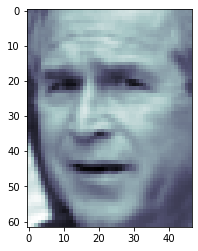

In [25]:
plt.imshow(X[259,:].reshape((h, w)), cmap=plt.cm.bone)

### Implementing a compression-decompression function
We now implement a function that first uses PCA to project samples in low-dimensions, and the reconstruct the original image.

In [26]:
def encode_decode_pca(A,m):
    """
    INPUT:
        A    [NxM] numpy data matrix (N samples, M features)
        m    integer number denoting the number of learned features (m <= M)
    
    OUTPUT:
        Ahat [NxM] numpy PCA reconstructed data matrix (N samples, M features)
    """
    
    eigvec, P = pca(A, m)
    Ahat = np.transpose(np.dot(eigvec, P.T))+np.mean(A)

    return Ahat

### Compressing and decompressing the data
We use the implemented function to encode and decode the data by projecting on a lower dimensional space of dimension 200 (m=200).

In [27]:
Xhat = encode_decode_pca((X[259,:]).reshape((h,w)), m=200)

### Inspecting the reconstructed data
Using the function *imshow* to plot and compare original and reconstructed pictures.

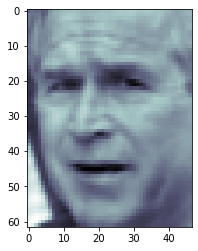

In [28]:
plt.imshow(Xhat.reshape((h, w)), cmap=plt.cm.bone)

Some of the highlights are gone for m=200, but all in all very little detail is lost. 
I aslo tried m=10 to see that the encoding and decoding actually does something, and that image did loose noticeable detail.

### Evaluating different compressions
We will use the previous setup to generate compressed images using different values of low dimensions in the PCA algorithm (e.g.: 100, 200, 500, 1000).

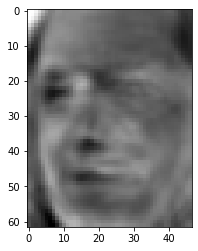

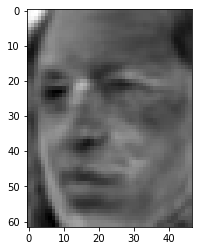

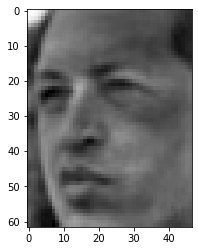

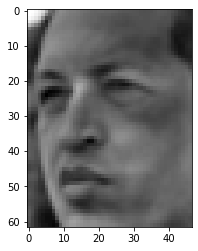

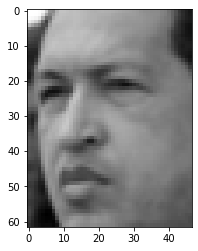

In [29]:
for i in [100, 200, 500, 1000]:
    Xhat = encode_decode_pca(X,i)
    plt.imshow(Xhat[0,:].reshape((h, w)), cmap=plt.cm.gray)
    plt.figure()
    
plt.imshow(X[0,:].reshape((h, w)), cmap=plt.cm.gray)

Here I can clearly see that detail is being lost for different m.
For the entire set I would not go lower than 200 dimensions as the image kind of looks like a seal with m=100

# K-Means Clustering
In this section we will use the *k-means clustering* algorithm to perform unsupervised clustering. Then perform a qualitative assesment of the results.

### Importing scikit-learn library
We start importing the module *cluster.KMeans* from *scikit-learn*.

In [34]:
from sklearn.cluster import KMeans

### Loading the data
We will use once again the *iris* data set. The function *get_iris_data()* from the module *syntethicdata* returns the *iris* dataset. It returns a data matrix of dimension [150x4] and a label vector of dimension [150].

In [35]:
X,y = syntheticdata.get_iris_data()

### Projecting the data using PCA
To allow for visualization, we project our data in two dimensions as we did previously. This step is not necessary, and we may want to try to use *k-means* later without the PCA pre-processing. However, we use PCA, as this will allow for an easy visualization.

In [36]:
_,P = pca(X,X.shape[0])

### Running k-means
We will now consider the *iris* data set as an unlabeled set, and perform clustering to this unlabeled set. We can compare the results of the clustering to the lableled calzones.

Use the class *KMeans* to fit and predict the output of the *k-means* algorithm on the projected data. Run the algorithm using the following values of $k=\{2,3,4,5\}$. 

In [37]:
for k in range(2,6):
    KM = KMeans(k)
    yhat2 = KM.fit_predict(P)

### Qualitative assessment
Here we plot the results of running the k-means algorithm and compare with the true labels.

Text(0.5, 1.0, 'Original data')

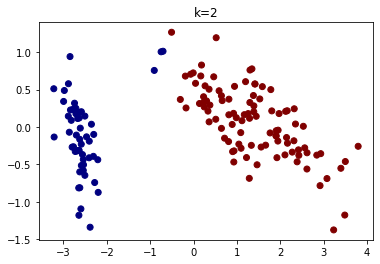

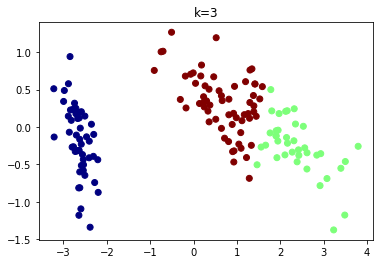

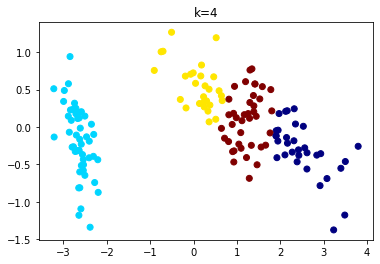

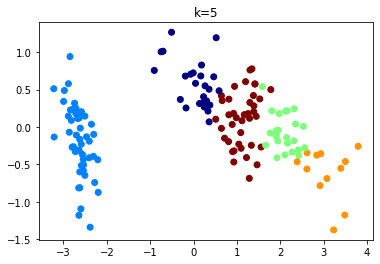

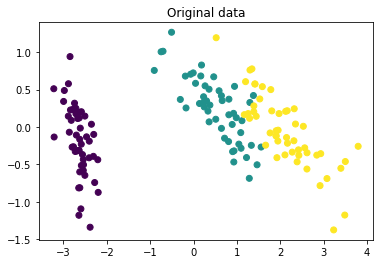

In [38]:
y_list = []

for k in range(2,6):
    KM = KMeans(k)
    yhat2 = KM.fit_predict(P)
    plt.scatter(P[:,0],P[:,1], c=yhat2, cmap=plt.cm.jet)
    plt.title('k='+str(k))
    plt.figure()
    y_list.append(yhat2)

plt.scatter(P[:,0],P[:,1],c=y)
plt.title('Original data')

k=3 gets about 80-90% right, but all the k's find it difficult to get the yellow points on the top correct.<br> It is a bit odd how k=2 chooses two of the points right next to the purple mass to be yellow.

# Quantitative Assessment of K-Means

We used k-means for clustering and we assessed the results qualitatively by visualizing them. However, we often want to be able to measure in a quantitative way how good the clustering was. To do this, we will use a classification task to evaluate numerically the goodness of the representation learned via k-means.

We reload the *iris* dataset. Import a standard `LogisticRegression` classifier from the module `sklearn.linear_model`. Use the k-means representations learned previously (`yhat2,...,yhat5`) and the true label to train the classifier. Evaluate the model on the training data (we do not have a test set, so this procedure will assess the model fit instead of generalization) using the `accuracy_score()` function from the *sklearn.metrics* module. And finally we plot a graph showing how the accuracy score varies when changing the value of k. 

0.9666666666666667


Text(0, 0.5, 'Accuracy')

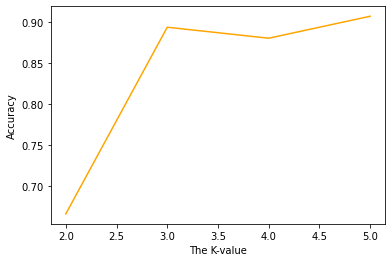

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

def one_hot(y):
    hot_dict = {0: [1,0,0,0,0], 1: [0,1,0,0,0], 2: [0,0,1,0,0], 3:[0,0,0,1,0], 4: [0,0,0,0,1]}
    return [hot_dict[e] for e in y]

# Train a Logistic regression model using the first two dimensions of the PCA
X,y = syntheticdata.get_iris_data()
_, P = pca(X, 2)
cls = LogisticRegression().fit(P,y)

# Report the model fit/accuracy on the training set.
print(metrics.accuracy_score(cls.predict(P),y))

k_accuracy = np.zeros(len(y_list))

# For each value of K:
for k in range(len(y_list)):
    
    # One-Hot-Encode the classes outputed by the K-means algorithm.
    hot_y_k = one_hot(y_list[k])
    
    # Train a Logistic regression model on the K-means classes as input vs the real classes as targets.
    cls = LogisticRegression().fit(hot_y_k, y)
    
    # Calculate model fit/accuracy vs. value of K.
    k_accuracy[k] = metrics.accuracy_score(cls.predict(hot_y_k),y)

plt.plot(range(2,2+len(y_list)), k_accuracy, c="orange")
plt.xlabel("The K-value")
plt.ylabel("Accuracy")

It seems to make better predictions for higher values of k, weird however that K=4 is worse than K=3.